**pix2pixとDCGANの違い**
- Generatorの損失関数に、L1lossを追加する
- Discriminatorの出力を1×1解像度でなく、14×14解像度などにして、Patch単位で正誤判定する

In [ ]:
# オリジナル画像からRGBのセグメント画像(3チャンネルのセグメント画像)を生成する
# 学習では、セグメント画像をPからRGBにして、それを正解データにする
# 画像領域分類タスクを画像生成タスクっぽくしてみる

In [ ]:
from datetime import datetime
import glob
import IPython
import os
import pickle
import PIL
import pprint
import random
import tqdm

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchvision
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Pascal VOC 2012データをダウンロード
torchvision.datasets.VOCDetection(root="./data",  # データが有る場合は参照先、無い場合はダウンロード先
                                  year="2012",  # 取得するPascal VOCデータセットの年度
                                  image_set="val",  # 取得するPascal VOCデータセットの種別  # trainやtrainvalだとデータ数が多いのでvalのみにする
                                  download=True,  # 引数rootのディレクトリにデータが無い場合にダウンロードするかどうか
                                  transform=None,  # 取得時に画像データへ行う処理
                                  target_transform=None)  # 取得時にラベルデータへ行う処理

In [ ]:
# Pascal VOC 2012データのvalのオリジナル画像とセグメント画像(RGB化)で教師データを準備
original_image_file_list = glob.glob("./data/VOCdevkit/VOC2012/JPEGImages/*.jpg")  # オリジナル画像のパスを全て取得
segment_image_file_list = glob.glob("./data/VOCdevkit/VOC2012/SegmentationClass/*.png")  # セグメント画像のパスを全て取得
original_image_RGB_PIL_list = []
segment_image_RGB_PIL_list = []
original_num_data = len(original_image_file_list)
segment_num_data = len(segment_image_file_list)
for i in range(segment_num_data):
    segment_image_file_name = segment_image_file_list[i][-15:-4]  # 1つ毎にセグメント画像のファイル名の番号部分を取得
    for j in range(original_num_data):
        original_image_file_name = original_image_file_list[j][-15:-4]  # 1つ毎にオリジナル画像のファイル名の番号部分を取得
        if original_image_file_name == segment_image_file_name:  # ファイル名の番号部分がオリジナル画像とセグメント画像で同じならば
            original_image_RGB_PIL = PIL.Image.open(original_image_file_list[j])  # 対象のオリジナル画像をPILへ変換
            segment_image_PIL = PIL.Image.open(segment_image_file_list[i])  # 対象のセグメント画像をPILへ変換
            segment_image_RGB_PIL = segment_image_PIL.convert(mode="RGB")  # セグメント画像のインデックスカラーをRGB(ダイレクトカラー)へ変換
            if len(np.array(original_image_RGB_PIL).shape) == 3:  # 画像が3階数テンソルならば
                original_image_RGB_PIL_list.append(original_image_RGB_PIL)  # PILのオリジナル画像をリストに保管(後続のDataset処理に向けて)
            if len(np.array(segment_image_RGB_PIL).shape) == 3:  # 画像が3階数テンソルならば
                segment_image_RGB_PIL_list.append(segment_image_RGB_PIL)  # PILでRGBにしたセグメント画像をリストに保管(後続のDataset処理に向けて)
        else:
            continue
print(len(original_image_RGB_PIL_list))
print(original_image_RGB_PIL_list[0])
print(np.array(original_image_RGB_PIL_list[0]).shape)
print("オリジナル画像")
IPython.display.display(original_image_RGB_PIL_list[0])
print(len(segment_image_RGB_PIL_list))
print(segment_image_RGB_PIL_list[0])
print(np.array(segment_image_RGB_PIL_list[0]).shape)
print("RGBにしたセグメント画像")
IPython.display.display(segment_image_RGB_PIL_list[0])

In [ ]:
# 教師データの80%をtrainデータ、20%をvalidationデータ
num_data = len(original_image_RGB_PIL_list)
train_original_image_RGB_PIL = original_image_RGB_PIL_list[:int(num_data*0.8)]
valid_original_image_RGB_PIL = original_image_RGB_PIL_list[int(num_data*0.8):]
train_segment_image_RGB_PIL = segment_image_RGB_PIL_list[:int(num_data*0.8)]
valid_segment_image_RGB_PIL = segment_image_RGB_PIL_list[int(num_data*0.8):]
print(len(train_original_image_RGB_PIL))
print(len(valid_original_image_RGB_PIL))

**前処理の準備**

In [ ]:
# データ拡張(Data Augmentation)を定義
image_transform_method = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224))])

In [ ]:
# 正規化とテンソル化を定義
def normalize_and_tensorize(PIL_image):
    numpy_image = np.array(PIL_image)
    numpy_image_for_torch = numpy_image.transpose(2, 0, 1)
    normalized_numpy_image = numpy_image_for_torch / 255
    normalized_tensor_image = torch.FloatTensor(normalized_numpy_image)
    return normalized_tensor_image

In [ ]:
# Datasetクラスを定義
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, input_PIL_image_list, answer_PIL_image_list, data_augmentation, tensorize):
        super().__init__()
        self.input_PIL_image_list = input_PIL_image_list
        self.answer_PIL_image_list = answer_PIL_image_list
        self.data_augmentation = data_augmentation
        self.tensorize = tensorize

    def __len__(self):
        return len(self.input_PIL_image_list)

    def __getitem__(self, idx):
        input_PIL_image = self.input_PIL_image_list[idx]
        augmentation_input_PIL_image = self.data_augmentation(input_PIL_image)
        input_tensor = self.tensorize(augmentation_input_PIL_image)
        answer_PIL_image = self.answer_PIL_image_list[idx]
        augmentation_answer_PIL_image = self.data_augmentation(answer_PIL_image)
        answer_tensor = self.tensorize(augmentation_answer_PIL_image)
        return input_tensor, answer_tensor

**前処理**

In [ ]:
train_dataset = MyDataset(input_PIL_image_list=train_original_image_RGB_PIL,
                          answer_PIL_image_list=train_segment_image_RGB_PIL,
                          data_augmentation=image_transform_method,
                          tensorize=normalize_and_tensorize)
valid_dataset = MyDataset(input_PIL_image_list=valid_original_image_RGB_PIL,
                          answer_PIL_image_list=valid_segment_image_RGB_PIL,
                          data_augmentation=image_transform_method,
                          tensorize=normalize_and_tensorize)

In [ ]:
train_dataset_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=20,
                                                       shuffle=None)
valid_dataset_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                       batch_size=20,
                                                       shuffle=None)

**pix2pixモデルを作成**

**Generator側のモデル(今回は256チャンネルまでの深さのU-Netっぽいものにする)**<br>
⇒入力を使って画像を出力させるので、encoder-decoder型のモデルを用いる

In [ ]:
class MyGenerator(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layer_1a_encoder = torch.nn.Conv2d(in_channels=in_dim, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer_1b_encoder = torch.nn.BatchNorm2d(num_features=64)
        self.layer_1c_encoder = torch.nn.ReLU()
        self.layer_1_to_2_down = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer_2a_encoder = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer_2b_encoder = torch.nn.BatchNorm2d(num_features=128)
        self.layer_2c_encoder = torch.nn.ReLU()
        self.layer_2_to_3_down = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer_3a_bridge = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer_3b_bridge = torch.nn.BatchNorm2d(num_features=256)
        self.layer_3c_bridge = torch.nn.ReLU()
        self.layer_3_to_4_up1 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.layer_3_to_4_up2 = torch.nn.BatchNorm2d(num_features=128)
        self.layer_3_to_4_up3 = torch.nn.ReLU()
        self.layer_4a_decoder = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer_4b_decoder = torch.nn.BatchNorm2d(num_features=128)
        self.layer_4c_decoder = torch.nn.ReLU()
        self.layer_4_to_5_up1 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.layer_4_to_5_up2 = torch.nn.BatchNorm2d(num_features=64)
        self.layer_4_to_5_up3 = torch.nn.ReLU()
        self.layer_5a_decoder = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer_5b_decoder = torch.nn.BatchNorm2d(num_features=64)
        self.layer_5c_decoder = torch.nn.ReLU()
        self.layer_5d_decoder = torch.nn.Conv2d(in_channels=64, out_channels=out_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, in_data):
        # print("in", in_data.shape)  # torch.Size([20, 3, 224, 224])
        out_data_layer_1a_encoder = self.layer_1a_encoder(in_data)
        out_data_layer_1b_encoder = self.layer_1b_encoder(out_data_layer_1a_encoder)
        out_data_layer_1c_encoder = self.layer_1c_encoder(out_data_layer_1b_encoder)
        # print("1", out_data_layer_1c_encoder.shape)  # torch.Size([20, 64, 224, 224])
        out_data_layer_1_to_2_down = self.layer_1_to_2_down(out_data_layer_1c_encoder)
        # print("1to2_down", out_data_layer_1_to_2_down.shape)  # torch.Size([20, 64, 112, 112])
        out_data_layer_2a_encoder = self.layer_2a_encoder(out_data_layer_1_to_2_down)
        out_data_layer_2b_encoder = self.layer_2b_encoder(out_data_layer_2a_encoder)
        out_data_layer_2c_encoder = self.layer_2c_encoder(out_data_layer_2b_encoder)
        # print("2", out_data_layer_2c_encoder.shape)  # torch.Size([20, 128, 112, 112])
        out_data_layer_2_to_3_down = self.layer_2_to_3_down(out_data_layer_2c_encoder)
        # print("2to3_down", out_data_layer_2_to_3_down.shape)  # torch.Size([20, 128, 56, 56])
        out_data_layer_3a_bridge = self.layer_3a_bridge(out_data_layer_2_to_3_down)
        out_data_layer_3b_bridge = self.layer_3b_bridge(out_data_layer_3a_bridge)
        out_data_layer_3c_bridge = self.layer_3c_bridge(out_data_layer_3b_bridge)
        # print("3", out_data_layer_3c_bridge.shape)  # torch.Size([20, 256, 56, 56])
        out_data_layer_3_to_4_up1 = self.layer_3_to_4_up1(out_data_layer_3c_bridge)
        out_data_layer_3_to_4_up2 = self.layer_3_to_4_up2(out_data_layer_3_to_4_up1)
        out_data_layer_3_to_4_up3 = self.layer_3_to_4_up3(out_data_layer_3_to_4_up2)
        # print("3to4_up", out_data_layer_3_to_4_up3.shape)  # torch.Size([20, 128, 112, 112])
        in_data_layer_4a_decoder = torch.cat([out_data_layer_3_to_4_up3, out_data_layer_2c_encoder], dim=1)
        # print("in4", in_data_layer_4a_decoder.shape)  # torch.Size([20, 256, 112, 112])
        out_data_layer_4a_decoder = self.layer_4a_decoder(in_data_layer_4a_decoder)
        out_data_layer_4b_decoder = self.layer_4b_decoder(out_data_layer_4a_decoder)
        out_data_layer_4c_decoder = self.layer_4c_decoder(out_data_layer_4b_decoder)
        # print("4", out_data_layer_4c_decoder.shape)  # torch.Size([20, 128, 112, 112])
        out_data_layer_4_to_5_up1 = self.layer_4_to_5_up1(out_data_layer_4c_decoder)
        out_data_layer_4_to_5_up2 = self.layer_4_to_5_up2(out_data_layer_4_to_5_up1)
        out_data_layer_4_to_5_up3 = self.layer_4_to_5_up3(out_data_layer_4_to_5_up2)
        # print("4to5_up", out_data_layer_4_to_5_up3.shape)  # torch.Size([20, 64, 224, 224])
        in_data_layer_5a_decoder = torch.cat([out_data_layer_4_to_5_up3, out_data_layer_1c_encoder], dim=1)
        # print("in5", in_data_layer_5a_decoder.shape)  # torch.Size([20, 128, 224, 224])
        out_data_layer_5a_decoder = self.layer_5a_decoder(in_data_layer_5a_decoder)
        out_data_layer_5b_decoder = self.layer_5b_decoder(out_data_layer_5a_decoder)
        out_data_layer_5c_decoder = self.layer_5c_decoder(out_data_layer_5b_decoder)
        # print("5", out_data_layer_5c_decoder.shape)  # torch.Size([20, 64, 224, 224])
        out_data_layer_5d_decoder = self.layer_5d_decoder(out_data_layer_5c_decoder)
        # print("out", out_data_layer_5d_decoder.shape)  # torch.Size([20, 3, 224, 224])
        return out_data_layer_5d_decoder

**Discriminator側のモデル(今回は256チャンネルまでの深さのU-Netっぽいもののencoder側をベースにする)**<br>
⇒入力を使ってTrueかFalseを出力させるので、encoder型のモデルに出力層を追加したものを用いる

In [ ]:
class MyDiscriminator(torch.nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.layer_1a = torch.nn.Conv2d(in_channels=in_dim, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.layer_1b = torch.nn.BatchNorm2d(num_features=16)
        self.layer_1c = torch.nn.ReLU()
        self.layer_1_to_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer_2a = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.layer_2b = torch.nn.BatchNorm2d(num_features=32)
        self.layer_2c = torch.nn.ReLU()
        self.layer_2_to_3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer_3a = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer_3b = torch.nn.BatchNorm2d(num_features=64)
        self.layer_3c = torch.nn.ReLU()
        self.layer_3_to_4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer_4a = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer_4b = torch.nn.BatchNorm2d(num_features=128)
        self.layer_4c = torch.nn.ReLU()
        self.layer_4_to_5 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer_5a = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer_5b = torch.nn.BatchNorm2d(num_features=256)
        self.layer_5c = torch.nn.ReLU()
        self.layer_6 = torch.nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1, padding=0)

    def forward(self, in_data):
        # print("in", in_data.shape)  # torch.Size([20, 3, 224, 224])
        out_data_layer_1a = self.layer_1a(in_data)
        out_data_layer_1b = self.layer_1b(out_data_layer_1a)
        out_data_layer_1c = self.layer_1c(out_data_layer_1b)
        # print("1", out_data_layer_1c.shape)  # torch.Size([20, 16, 224, 224])
        out_data_layer_1_to_2 = self.layer_1_to_2(out_data_layer_1c)
        # print("1to2", out_data_layer_1_to_2.shape)  # torch.Size([20, 16, 112, 112])
        out_data_layer_2a = self.layer_2a(out_data_layer_1_to_2)
        out_data_layer_2b = self.layer_2b(out_data_layer_2a)
        out_data_layer_2c = self.layer_2c(out_data_layer_2b)
        # print("2", out_data_layer_2c.shape)  # torch.Size([20, 32, 112, 112])
        out_data_layer_2_to_3 = self.layer_2_to_3(out_data_layer_2c)
        # print("2to3", out_data_layer_2_to_3.shape)  # torch.Size([20, 32, 56, 56])
        out_data_layer_3a = self.layer_3a(out_data_layer_2_to_3)
        out_data_layer_3b = self.layer_3b(out_data_layer_3a)
        out_data_layer_3c = self.layer_3c(out_data_layer_3b)
        # print("3", out_data_layer_3c.shape)  # torch.Size([20, 64, 56, 56])
        out_data_layer_3_to_4 = self.layer_3_to_4(out_data_layer_3c)
        # print("3to4", out_data_layer_3_to_4.shape)  # torch.Size([20, 64, 28, 28])
        out_data_layer_4a = self.layer_4a(out_data_layer_3_to_4)
        out_data_layer_4b = self.layer_4b(out_data_layer_4a)
        out_data_layer_4c = self.layer_4c(out_data_layer_4b)
        # print("4", out_data_layer_4c.shape)  # torch.Size([20, 128, 28, 28])
        out_data_layer_4_to_5 = self.layer_4_to_5(out_data_layer_4c)
        # print("4to5", out_data_layer_4_to_5.shape)  # torch.Size([20, 128, 14, 14])
        out_data_layer_5a = self.layer_5a(out_data_layer_4_to_5)
        out_data_layer_5b = self.layer_5b(out_data_layer_5a)
        out_data_layer_5c = self.layer_5c(out_data_layer_5b)
        # print("5", out_data_layer_5c.shape)  # torch.Size([20, 256, 14, 14])
        out_data_layer_6 = self.layer_6(out_data_layer_5c)
        # print("out", out_data_layer_6.shape)  # torch.Size([20, 1, 14, 14])
        return out_data_layer_6

**モデル、損失関数、最適化アルゴリズム**

In [ ]:
nn_model_G = MyGenerator(in_dim=3, out_dim=3).to(device)  # Generatorモデル # GPUへ
nn_model_D = MyDiscriminator(in_dim=3).to(device)  # Discriminatorモデル # GPUへ
loss_BCE = torch.nn.BCEWithLogitsLoss()  # BinaryCrossEntropylossにSigmoidを組み合わせたもの
coefficient = 100  # 損失値の計算の時にL1Lossに掛ける係数
loss_MAE = torch.nn.L1Loss()  # MeanAbsoluteError
optimizer_G = torch.optim.Adam(nn_model_G.parameters(), lr=0.001)  # Generatorモデル向け最適化アルゴリズム
optimizer_D = torch.optim.Adam(nn_model_D.parameters(), lr=0.001)  # Discriminatorモデル向け最適化アルゴリズム

In [ ]:
# Generatorモデル
torchinfo.summary(nn_model_G, input_size=(20, 3, 224, 224), depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
MyGenerator                              [20, 3, 224, 224]         --
├─Conv2d: 1-1                            [20, 64, 224, 224]        1,792
├─BatchNorm2d: 1-2                       [20, 64, 224, 224]        128
├─ReLU: 1-3                              [20, 64, 224, 224]        --
├─MaxPool2d: 1-4                         [20, 64, 112, 112]        --
├─Conv2d: 1-5                            [20, 128, 112, 112]       73,856
├─BatchNorm2d: 1-6                       [20, 128, 112, 112]       256
├─ReLU: 1-7                              [20, 128, 112, 112]       --
├─MaxPool2d: 1-8                         [20, 128, 56, 56]         --
├─Conv2d: 1-9                            [20, 256, 56, 56]         295,168
├─BatchNorm2d: 1-10                      [20, 256, 56, 56]         512
├─ReLU: 1-11                             [20, 256, 56, 56]         --
├─ConvTranspose2d: 1-12                  [20, 128, 112, 112]       295

In [ ]:
# Discriminatorモデル
torchinfo.summary(nn_model_D, input_size=(20, 3, 224, 224), depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
MyDiscriminator                          [20, 1, 14, 14]           --
├─Conv2d: 1-1                            [20, 16, 224, 224]        448
├─BatchNorm2d: 1-2                       [20, 16, 224, 224]        32
├─ReLU: 1-3                              [20, 16, 224, 224]        --
├─MaxPool2d: 1-4                         [20, 16, 112, 112]        --
├─Conv2d: 1-5                            [20, 32, 112, 112]        4,640
├─BatchNorm2d: 1-6                       [20, 32, 112, 112]        64
├─ReLU: 1-7                              [20, 32, 112, 112]        --
├─MaxPool2d: 1-8                         [20, 32, 56, 56]          --
├─Conv2d: 1-9                            [20, 64, 56, 56]          18,496
├─BatchNorm2d: 1-10                      [20, 64, 56, 56]          128
├─ReLU: 1-11                             [20, 64, 56, 56]          --
├─MaxPool2d: 1-12                        [20, 64, 28, 28]          --
├─Conv

**学習と検証**

In [ ]:
if os.path.isfile("./epoch_train_loss_G_total_list.pkl"):
    with open("./epoch_train_loss_G_total_list.pkl", mode="rb") as f:
        epoch_train_loss_G_total_list = pickle.load(f)
else:
    epoch_train_loss_G_total_list = []
if os.path.isfile("./epoch_train_loss_D_total_list.pkl"):
    with open("./epoch_train_loss_D_total_list.pkl", mode="rb") as f:
        epoch_train_loss_D_total_list = pickle.load(f)
else:
    epoch_train_loss_D_total_list = []
if os.path.isfile("./epoch_valid_loss_G_total_list.pkl"):
    with open("./epoch_valid_loss_G_total_list.pkl", mode="rb") as f:
        epoch_valid_loss_G_total_list = pickle.load(f)
else:
    epoch_valid_loss_G_total_list = []
if os.path.isfile("./epoch_valid_loss_D_total_list.pkl"):
    with open("./epoch_valid_loss_D_total_list.pkl", mode="rb") as f:
        epoch_valid_loss_D_total_list = pickle.load(f)
else:
    epoch_valid_loss_D_total_list = []
if os.path.isfile("./FineTuning_pix2pix_G.model"):
    nn_model_G.load_state_dict(torch.load("./FineTuning_pix2pix_G.model"))
if os.path.isfile("./FineTuning_pix2pix_D.model"):
    nn_model_D.load_state_dict(torch.load("./FineTuning_pix2pix_D.model"))
# エポック毎に学習と検証
for epoch in tqdm.notebook.tqdm(range(10)):
    # 学習
    epoch_train_loss_G_total = 0
    epoch_train_loss_D_total = 0
    nn_model_G.train()
    nn_model_D.train()
    for train_input_tensor_minibatch, train_answer_tensor_minibatch in train_dataset_dataloader:
        train_input_tensor_minibatch = train_input_tensor_minibatch.to(device)  # GPUへ
        train_answer_tensor_minibatch = train_answer_tensor_minibatch.to(device)  # GPUへ
        output_model_G = nn_model_G(in_data=train_input_tensor_minibatch)  # 入力データを使って、Gモデルで画像生成
        output_model_G_copy = output_model_G.detach()  # 後続で再度使うのでGモデル生成画像をコピー(pytorchでは同じ変数の値を学習に2回使えないため)
        output_model_D_by_G = nn_model_D(in_data=output_model_G)  # Gモデル生成画像に対して、Dモデルで判定出力
        true_label_for_D = torch.ones(size=output_model_D_by_G.shape).to(device)  # Discriminatorモデル向けのTrueラベル # GPUへ
        false_label_for_D = torch.zeros(size=output_model_D_by_G.shape).to(device)  # Discriminatorモデル向けのFalseラベル # GPUへ
        # ↓ここからGenerationモデル向けの学習↓
        loss_for_G_1 = loss_BCE(output_model_D_by_G, true_label_for_D)  # Gモデル向けの1つ目の損失値 # Dモデルの判定をTrueにしたいので、Trueラベルとの差異を最小にしたい
        loss_for_G_2 = loss_MAE(output_model_G, train_answer_tensor_minibatch)  # Gモデル向けの2つ目の損失値 # Gモデルの生成画像と、正解画像との差異を最小にしたい
        loss_G = loss_for_G_1 + (coefficient * loss_for_G_2)  # Gモデル向けの損失値(1つ目の損失値と、係数を掛けた2つ目の損失値の合算)
        optimizer_G.zero_grad()
        # optimizer_D.zero_grad()  # この勾配リセットは無くてイイような(https://github.com/YutaroOgawa/pytorch_advanced/issues/86)
        loss_G.backward()
        optimizer_G.step()
        epoch_train_loss_G_total = epoch_train_loss_G_total + loss_G.item()
        # ↑ここまでがGenerationモデル向けの学習↑
        output_model_D_by_G_copy = nn_model_D(in_data=output_model_G_copy)  # Gモデル生成画像コピーに対して、Dモデルで判定出力
        output_model_D_by_answer = nn_model_D(in_data=train_answer_tensor_minibatch)  # 正解画像に対して、Dモデルで判定出力
        # ↓ここからDiscriminatorモデル向けの学習↓
        loss_for_D_1 = loss_BCE(output_model_D_by_G_copy, false_label_for_D)  # Dモデル向けの1つ目の損失値 # Dモデルの判定をFalseにしたいので、Falseラベルとの差異を最小にしたい
        loss_for_D_2 = loss_BCE(output_model_D_by_answer, true_label_for_D)  # Dモデル向けの2つ目の損失値 # Dモデルの判定をTrueにしたいので、Trueラベルとの差異を最小にしたい
        loss_D = loss_for_D_1 + loss_for_D_2
        # optimizer_G.zero_grad()  # この勾配リセットは無くてイイような
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        epoch_train_loss_D_total = epoch_train_loss_D_total + loss_D.item()
        # ↑ここまでがDiscriminatorモデル向けの学習↑
    epoch_train_loss_G_total_list.append(epoch_train_loss_G_total)
    with open("./epoch_train_loss_G_total_list.pkl", mode="wb") as f:
        pickle.dump(obj=epoch_train_loss_G_total_list, file=f)
    epoch_train_loss_D_total_list.append(epoch_train_loss_D_total)
    with open("./epoch_train_loss_D_total_list.pkl", mode="wb") as f:
        pickle.dump(obj=epoch_train_loss_D_total_list, file=f)
    torch.save(nn_model_G.state_dict(), "./FineTuning_pix2pix_G.model")
    torch.save(nn_model_D.state_dict(), "./FineTuning_pix2pix_D.model")
    # 検証
    epoch_valid_loss_G_total = 0
    epoch_valid_loss_D_total = 0
    nn_model_G.eval()
    nn_model_D.eval()
    with torch.no_grad():
        for valid_input_tensor_minibatch, valid_answer_tensor_minibatch in valid_dataset_dataloader:
            valid_input_tensor_minibatch = valid_input_tensor_minibatch.to(device)  # GPUへ
            valid_answer_tensor_minibatch = valid_answer_tensor_minibatch.to(device)  # GPUへ
            predict_model_G = nn_model_G(in_data=valid_input_tensor_minibatch)
            predict_model_G_copy = predict_model_G.detach()
            predict_model_D_by_G = nn_model_D(in_data=predict_model_G)
            true_label_for_D = torch.ones(size=predict_model_D_by_G.shape).to(device)  # GPUへ
            false_label_for_D = torch.zeros(size=predict_model_D_by_G.shape).to(device)  # GPUへ
            # ↓ここからGenerationモデル向けの検証↓
            loss_for_G_1 = loss_BCE(predict_model_D_by_G, true_label_for_D)  # Gモデルとしては、Gモデル生成画像をDモデルにTrue判定してほしい
            loss_for_G_2 = loss_MAE(predict_model_G, valid_answer_tensor_minibatch)  # Gモデルとしては、Gモデル生成画像と正解画像を同じにしたい
            loss_G = loss_for_G_1 + (coefficient * loss_for_G_2)
            epoch_valid_loss_G_total = epoch_valid_loss_G_total + loss_G.item()
            # ↑ここまでがGenerationモデル向けの検証↑
            predict_model_D_by_G_copy = nn_model_D(in_data=predict_model_G_copy)
            predict_model_D_by_answer = nn_model_D(in_data=valid_answer_tensor_minibatch)
            # ↓ここからDiscriminatorモデル向けの検証↓
            loss_for_D_1 = loss_BCE(predict_model_D_by_G_copy, false_label_for_D)  # Dモデルとしては、Gモデル生成画像をDモデルはFalse判定したい
            loss_for_D_2 = loss_BCE(predict_model_D_by_answer, true_label_for_D)  # Dモデルとしては、正解画像をDモデルはTrue判定したい
            loss_D = loss_for_D_1 + loss_for_D_2
            epoch_valid_loss_D_total = epoch_valid_loss_D_total + loss_D.item()
            # ↑ここまでがDiscriminatorモデル向けの検証↑
        epoch_valid_loss_G_total_list.append(epoch_valid_loss_G_total)
        with open("./epoch_valid_loss_G_total_list.pkl", mode="wb") as f:
            pickle.dump(obj=epoch_valid_loss_G_total_list, file=f)
        epoch_valid_loss_D_total_list.append(epoch_valid_loss_D_total)
        with open("./epoch_valid_loss_D_total_list.pkl", mode="wb") as f:
            pickle.dump(obj=epoch_valid_loss_D_total_list, file=f)

In [ ]:
with open("./epoch_train_loss_G_total_list.pkl", mode="rb") as f:
    epoch_train_loss_G_total_list = pickle.load(f)
with open("./epoch_train_loss_D_total_list.pkl", mode="rb") as f:
    epoch_train_loss_D_total_list = pickle.load(f)
with open("./epoch_valid_loss_G_total_list.pkl", mode="rb") as f:
    epoch_valid_loss_G_total_list = pickle.load(f)
with open("./epoch_valid_loss_D_total_list.pkl", mode="rb") as f:
    epoch_valid_loss_D_total_list = pickle.load(f)

In [ ]:
x_datas = np.arange(1, len(epoch_train_loss_G_total_list)+1, 1)
y_datas_list_G = [epoch_train_loss_G_total_list, epoch_valid_loss_G_total_list]
y_datas_list_D = [epoch_train_loss_D_total_list, epoch_valid_loss_D_total_list]
labels = ["train", "valid"]
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)
label2color = colors[:len(labels)]

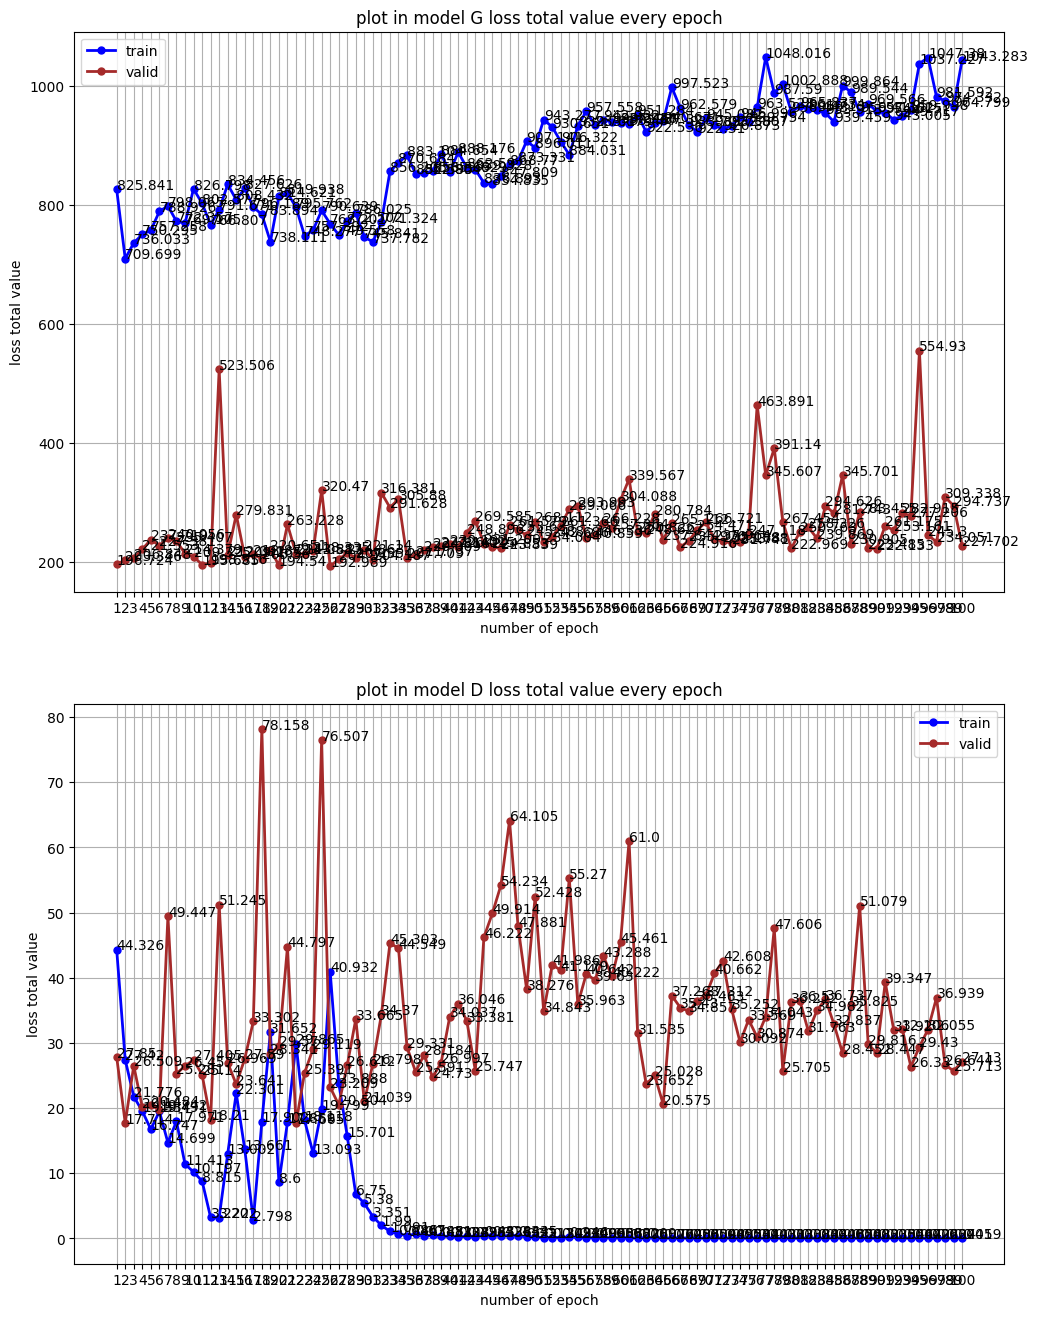

In [ ]:
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))
for i, y_datas_G in enumerate(y_datas_list_G):
    axes1.plot(x_datas, y_datas_G, label=labels[i], c=label2color[i], marker="o", markersize=5, linestyle="solid", linewidth=2)
    for j in range(len(y_datas_G)):
        axes1.annotate(text=round(y_datas_G[j], 3), xy=(x_datas[j], y_datas_G[j]))
axes1.legend()
axes1.set_title("plot in model G loss total value every epoch")
axes1.set_xlabel("number of epoch")
axes1.set_ylabel("loss total value")
axes1.set_xticks(ticks=x_datas)
axes1.grid(True)
for i, y_datas_D in enumerate(y_datas_list_D):
    axes2.plot(x_datas, y_datas_D, label=labels[i], c=label2color[i], marker="o", markersize=5, linestyle="solid", linewidth=2)
    for j in range(len(y_datas_D)):
        axes2.annotate(text=round(y_datas_D[j], 3), xy=(x_datas[j], y_datas_D[j]))
axes2.legend()
axes2.set_title("plot in model D loss total value every epoch")
axes2.set_xlabel("number of epoch")
axes2.set_ylabel("loss total value")
axes2.set_xticks(ticks=x_datas)
axes2.grid(True)
plt.show()

**検証**

In [ ]:
if os.path.isfile("./FineTuning_pix2pix_G.model"):
    nn_model_G.load_state_dict(torch.load("./FineTuning_pix2pix_G.model"))
if os.path.isfile("./FineTuning_pix2pix_D.model"):
    nn_model_D.load_state_dict(torch.load("./FineTuning_pix2pix_D.model"))
nn_model_G.eval()
nn_model_D.eval()
with torch.no_grad():
    predict_model_G_vector_list = []
    valid_answer_vector_list = []
    valid_input_vector_list = []
    for valid_input_tensor_minibatch, valid_answer_tensor_minibatch in tqdm.notebook.tqdm(valid_dataset_dataloader):
        valid_input_tensor_minibatch = valid_input_tensor_minibatch.to(device)  # GPUへ
        valid_answer_tensor_minibatch = valid_answer_tensor_minibatch.to(device)  # GPUへ
        predict_model_G = nn_model_G(in_data=valid_input_tensor_minibatch)
        predict_model_G_array = predict_model_G.detach().cpu().numpy()  # 微分を外して、CPUへ移して、numpyにする
        predict_model_G_array_for_PIL = predict_model_G_array.transpose(0, 2, 3, 1)  # 形状を(ミニバッチ数, 縦, 横, チャンネル)にする
        predict_model_G_array_denormalized_for_PIL = (predict_model_G_array_for_PIL * 255).astype(dtype=np.uint8)  # 255を掛けて正規化を戻して、データ型をuint8にする
        predict_model_G_vector_list.append(predict_model_G_array_denormalized_for_PIL)
        valid_answer_array = valid_answer_tensor_minibatch.detach().cpu().numpy()  # 正解画像テンソルにも同様の処理をする
        valid_answer_array_for_PIL = valid_answer_array.transpose(0, 2, 3, 1)
        valid_answer_array_denormalized_for_PIL = (valid_answer_array_for_PIL * 255).astype(dtype=np.uint8)
        valid_answer_vector_list.append(valid_answer_array_denormalized_for_PIL)
        valid_input_array = valid_input_tensor_minibatch.detach().cpu().numpy()  # 入力画像テンソルにも同様の処理をする
        valid_input_array_for_PIL = valid_input_array.transpose(0, 2, 3, 1)
        valid_input_array_denormalized_for_PIL = (valid_input_array_for_PIL * 255).astype(dtype=np.uint8)
        valid_input_vector_list.append(valid_input_array_denormalized_for_PIL)
    predict_model_G_vector_all = np.concatenate(predict_model_G_vector_list, axis=0)
    print("predict_model_G_vector_all", predict_model_G_vector_all.shape)
    valid_answer_vector_all = np.concatenate(valid_answer_vector_list, axis=0)
    print("valid_answer_vector_all", valid_answer_vector_all.shape)
    valid_input_vector_all = np.concatenate(valid_input_vector_list, axis=0)
    print("valid_input_vector_all", valid_input_vector_all.shape)

  0%|          | 0/11 [00:00<?, ?it/s]

predict_model_G_vector_all (211, 224, 224, 3)
valid_answer_vector_all (211, 224, 224, 3)
valid_input_vector_all (211, 224, 224, 3)


In [ ]:
valid_input_PIL = PIL.Image.fromarray(valid_input_vector_all[0], mode="RGB")
IPython.display.display(valid_input_PIL)

In [ ]:
valid_answer_PIL = PIL.Image.fromarray(valid_answer_vector_all[0], mode="RGB")
IPython.display.display(valid_answer_PIL)

100epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

90epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

80epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

70epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

60epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

50epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

40epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

30epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

20epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)

10epoch学習後の推測結果

In [ ]:
predict_model_G_PIL = PIL.Image.fromarray(predict_model_G_vector_all[0], mode="RGB")
IPython.display.display(predict_model_G_PIL)